0. Abstract
CNN在supervised learning 领域取得了非常了不起的成就(比如大规模的图片分类，目标检测等等)，但是在unsupervised learning领域却没有特别大的进展。所以作者想弥补CNN在supervised 和 unsupervised之间的隔阂（gap）。作者提出了 将CNN和GAN相结合 的DCGAN,并展示了它在unsupervised learning所取得的不俗的成绩。作者通过在大量不同的image datasets上的训练，充分展示了DCGAN的generator(生成器)和discriminator(鉴别器)不论是在物体的组成部分(parts of object)还是场景方面(scenes)都学习到了丰富的层次表达(hierarchy representations)。作者还将学习到的特征应用于新的任务上(比如image classification),结果表明这些特征是非常好的通用图片表达(具有非常好的泛化能力)。

1. Introduction
这篇文章在以下几个方面做出了贡献:

- 文中提出并评估了一系列的对于卷积GAN的结构的限制（注：DCGAN的网络结构在之后的许多改进GAN中也得到了沿用），这些限制确保了在大多数情况下,卷积GAN可以保持稳定。文中将这种结构命名为DCGAN。
- 文中将 训练好的鉴别器应用于图片分类任务，并和其他的非监督方法进行对比，发现它非常competitive。
- 文中可视化了DCGAN的filters,结果表明特定的filter学习到了特定的object。
- 文中表明生成器具有有趣的向量算数属性(vector arithmetic property),这使得我们可以对生成的样本进行语义上的操作(类似于NLP中的word embedding 的性质,文中作者举了给女性戴墨镜的例子,详见下文)。
2. 实验
文章主要在LSUN数据集,ImageNet 1k以及一个较新的celebA数据集上进行了实验。训练的一些细节如下:

image preprocessing。我们没有对图片进行pre-processing,除了将generator的输出变换到[-1,1]。
SGD。训练使用mini-batch SGD,batch size = 128。
parameters initialize。所有的参数都采用0均值,标准差为0.02的初始化方式。
leaky relu。leaky relu 的 α的取值为0.2。
optimizers。我们使用Adam optimizer,并且对参数做了一些fine tuing,我们实验发现默认的学习率为0.001,太高了，我们调整为0.0002。Adam中的momentum term β1=0.9太高了，会使得训练过程震荡，不稳定，我们将其调整为0.5发现可以使训练过程更加稳定。910


DCGAN主要是在网络架构上改进了原始GAN，DCGAN的生成器与判别器都利用CNN架构替换了原始GAN的全连接网络，主要改进之处有如下几个方面：

DCGAN的生成器和判别器都舍弃了CNN的池化层，判别器保留CNN的整体架构，生成器则是将卷积层替换成了反卷积层（fractional-strided convolution）或者叫转置卷积层（Convolution Transpose）。
在判别器和生成器中在每一层之后都是用了Batch Normalization（BN）层，有助于处理初始化不良导致的训练问题，加速模型训练，提升了训练的稳定性。
利用1*1卷积层替换到所有的全连接层。
在生成器中除输出层使用Tanh（Sigmoid）激活函数，其余层全部使用ReLu激活函数。
在判别器所有层都使用LeakyReU激活函数，防止梯度稀。

![](./G.png)
![](./D.png)

images[0].shape torch.Size([1, 64, 64])
tensor([5, 5, 7, 5, 5])


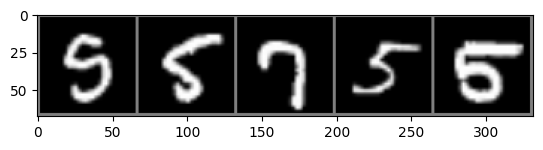

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt

data_tf = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

# 补充说明

# transform.ToTensor() 作用是
# 将输入的数据shape H，W，C —> C，H，W
# 将所有数除以255.0，将数据归一化到【0，1】

# transforms.Normalize 计算公式为 x = (x - mean) / std
# 这里数据集是灰度图像只有一个通道，所以取了 [0.5],[0.5]，若是RGB图像参数格式应为 [0.5,0.5,0.5],[0.5,0.5,0.5] 
# 这里的 0.5 仅仅是此数据集的均值和方差，具体的取值要根据自己的数据集自行计算
# transforms.Normalize 经过这样处理后将数据的【每个channel】 标准化，即均值为0，标准差为1。使模型更容易收敛。并非是归于【-1，1】
# 另外 normalize 之后并不是正态分布，具体是什么分布取决于数据本身的分布
# 将标准化数据 转回 图片数据 只需要逆运算即可, x = x * std + mean

train_dataset = datasets.MNIST(root='./MNIST',train=True,transform=data_tf,download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=5,
                                           shuffle=True)
# 实现单张图片可视化
images, labels = next(iter(train_loader))

print('images[0].shape', images[0].shape) 

img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1, 2, 0) 
std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
img = img * std + mean #逆运算
print(labels)
plt.imshow(img)
plt.show()

In [ ]:
import argparse
import os                    
import numpy as np           
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable      

import torch.nn as nn
import torch.nn.functional as F
import torch


os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()          #命令行选项、参数和子命令解析器
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")  #迭代次数
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")          #batch大小
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")            #学习率
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient") #动量梯度下降第一个参数
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient") #动量梯度下降第二个参数
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation") #CPU个数
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")  #噪声数据生成维度
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")  #输入数据的维度
parser.add_argument("--channels", type=int, default=1, help="number of image channels")      #输入数据的通道数
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")  #保存图像的迭代数
opt = parser.parse_args()
print(opt)

cuda = True if torch.cuda.is_available() else False 

![](./G.png)

https://zhuanlan.zhihu.com/p/379330500
严格按照图中的结构搭建模型:
1. 输入噪声 100 维
2. Linear层 100 -> 
3. 通过 upsample 和 reshape 

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size =  opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2)) #l1函数进行Linear变换。线性变换的两个参数是变换前的维度，和变换之后的维度

        self.conv_blocks = nn.Sequential(           #nn.sequential{}是一个组成模型的壳子，用来容纳不同的操作
            nn.BatchNorm2d(128),                    # BatchNorm2d的目的是使我们的一批（batch）feature map 满足均值0方差1，就是改变数据的量纲
            nn.Upsample(scale_factor=2),            #上采样，将图片放大两倍（这就是为啥class最先开始将图片的长宽除了4，下面还有一次放大2倍）
            nn.Conv2d(128, 128, 3, stride=1, padding=1), #二维卷积函数，（输入数据channel，输出的channel，步长，卷积核大小，padding的大小）
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),        #relu激活函数
            nn.Upsample(scale_factor=2),            #上采样
            nn.Conv2d(128, 64, 3, stride=1, padding=1),#二维卷积
            nn.BatchNorm2d(64, 0.8),                #BN
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),                              #Tanh激活函数
        )

    def forward(self, z):
        out = self.l1(z)              #l1函数进行的是Linear变换 （第50行定义了）
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)#view是维度变换函数，可以看到out数据变成了四维数据，第一个是batch_size(通过整个的代码，可明白),第二个是channel，第三,四是单张图片的长宽
        img = self.conv_blocks(out)
        return img